# Check current Implementation of I.org and its Interpretation

In [253]:
%matplotlib inline

import os, sys, glob, copy
import pylab as pl
pl.rcParams['font.size'] = 16.0


#pl.matplotlib.rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})

import numpy as np
import datetime
import scipy.spatial

sys.path.append('../../tools/ieda_caipy_devel/')
from utility_functions import nne_size
from indices import calculate_Iorg as calculate_Iorg_Ieda

## Test Scene

In [80]:
xbins = np.linspace(0,1000,500)*1e3
ybins = np.linspace(1000,2000,400)*1e3

egrid = np.meshgrid(xbins, ybins)
#egrid = (xbins, ybins)


In [254]:
ncells = 10
xpos = np.random.uniform(xbins.min(), xbins.max(), ncells)
ypos = np.random.uniform(ybins.min(), ybins.max(), ncells)
sizes = np.random.uniform( 4, 50, ncells)

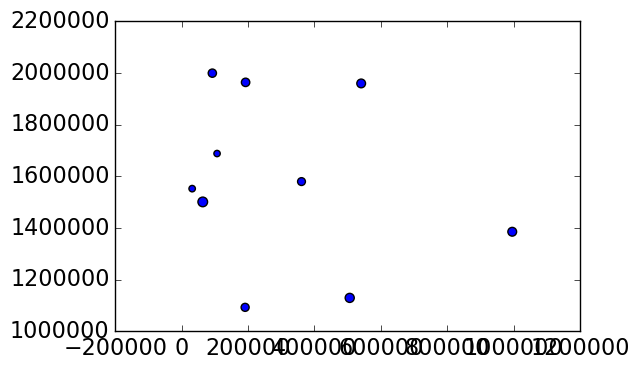

In [255]:
pl.scatter(xpos, ypos, s = sizes, marker = 'o')

## Try a new modularization of I.org calculation

In [231]:
def nncdf_Ieda(x_clm, y_clm, r_equ, 
                   dscale = 1e-3,
                   max_dist = 1000. , 
                   dist_interval = 1.,):
    
    # get number of cells
    N_c = len(x_clm)
        
    # Array of shape (N_cl,2), containing the coordinates in meters
    coords_clm = np.transpose(np.vstack((x_clm, y_clm)))

    # Euclidean Distance between each pair of the two input arrays
    # Output: distance of pairs in a symmetric and trace-less matrix as 
    # two input arrays are identical
    # The distance is given in meters
    dist_clm = scipy.spatial.distance.cdist(coords_clm, coords_clm, 'euclidean')


    # Change dist_clm from m to km
    dist_clm = dist_clm * dscale
   


    # Adapt the distance to acount for the size of the 
    # objects (Iedas function nne_size reduces the distance based on centers
    # of mass by the equivalent radii of the two objects considered)
    # nne_size also replaces trace of the matrix with nan, trace elements contain 
    # zero distance as they reflect the distance between the same object
    dist_size = nne_size(dist_clm, r_equ)
    
     
    # nne_size can lead to negative distances in case the equivalent radius is larger than the distance 
    # occurs if two objects are closer to each other than their equivalent radii
    # These distances are then replaced by NAN. 
    dist_size[np.where(dist_size <= 0.)] = np.nan 


    if (len(np.where(dist_size <= 0.)[0]) > 0.):
       sys.exit('dist_size is <= zero !')
    

    # Number of elements in dist_size not containing nan
    n_dist_size = np.count_nonzero(~np.isnan(dist_size))


    # Distances (in km) for which the NNCDF is computed
    # Bin width = dist_interval km

    dist = np.arange( 0., max_dist, dist_interval) 


    # Calculate NNCDF only in case that dist_size array contains at least two objects
    # and not only NaN entries

    if n_dist_size > 0:

        # NN distance
        nnd=np.zeros(N_c)
        nnd[:]=np.nan
        # only NN distance is retained
        for ob in range(N_c):
            nnd[ob]=np.sort(dist_size[ob,:])[0]
            nnaux=nnd[ob]
            


        # NNCDF of the objects based on observations (fractional number of objects whose NN distance is <=r)
        frac=[]
        for fr in dist:
            fra = np.count_nonzero(nnd <=fr)/(float(nnd.shape[0]))
            frac.append(fra)

        # Observed NNCDF     
        Fo = np.asarray(frac)   
        
    return dist, nnd, Fo
    

In [233]:
def boot_objects( grid, n, size ):
    
    # selected new sizes
    new_size = np.random.choice(size, n)
    
    
    # get external grid
    x_lon, y_lat = grid[0].flatten(), grid[1].flatten()

    
    # redistribution of the objects in space 
    ind = np.random.choice(a = range(len(x_lon)), size = n)
    new_xpos = x_lon[ind]
    new_ypos = y_lat[ind]

    
    return new_xpos, new_ypos, new_size
    


In [246]:

##########################################################################
##########################################################################

def calculate_Iorg(x_clm, y_clm, r_equ, grid, 
                   max_dist = 1000. , 
                   dist_interval = 1.,
                   number_of_repetitions = 100, 
                   full_output = False):
         
    '''
    Calculates the organization index (Tompkins and Semi (2017), Nair et al. (1998))
    
    INPUT
    =====
    x_clm: x-coordinates of objects in meters 
    y_clm: y-coordiantes of objects in meters
    r_equ: equivalent radii of objects
    grid: meshgrid  where objects are defined in
    max_dist: maximal distance in km for which the NNCDF is computed 
    dist_interval: bin width in km for the distance vector
    number_of_repetitions: number of repetitions for the bootstraping
    full_output: full_output=True gives NNCDFs
    

    OUTPUT
    ======
    Iorg: organization index
    UP: Iorg + 1.96STD
    LW: Iorg - 1.96STD
    dist: distances in km for which the NNCDF is computed
    Fo: observed nearest neighbor cumulative distribution function
    Fs: simulated nearest neighbor cumulative distribution function
    Fm: mean of nreps NNCDFs (the inhibition NNCDF)
    Fmh: Fm + 1.96STD
    Fml: Fm - 1.96STD
    '''    

    # number of repetitions for the bootstrapping
    nreps = number_of_repetitions 

    
    # Number of clusters
    N_c = len( x_clm )
    
    
    # get NNCDF for observation
    print x_clm.shape, y_clm.shape, r_equ.shape
    dist_bins, nnd, Fo = nncdf_Ieda(x_clm, y_clm, r_equ, 
                                    dscale = 1e-3,
                                    max_dist = max_dist , 
                                    dist_interval = dist_interval)
    

    nbins = len(Fo)

    
    # ####################################################################################  
    # BOOTSTRAPING: statistical method to resample
    # ####################################################################################

    print '   BOOTSTRAPING'
       
    print 'number of repetitions = ', nreps 

    Fs = np.zeros((nreps, nbins))
    Iorg = np.zeros((nreps))
    
    for i in range(nreps):
          
        # Avoid to have only one single object in dist_sim, so draw new sample in that case.
        # Might occur in case total number of objects is very low (2-5)
        new_N = 0
        while new_N < 2:
            # draws samples from a Poisson distribution with lambda=N_c, 
            # lambda=variance and expected value
            new_N = np.random.poisson(N_c) # take out one sample

            
        # get new position from random bootstrapping
        x_boot, y_boot, r_boot = boot_objects( grid, new_N, r_equ )
        
        
        # get NNCDF for observation
        dist_bins, nnd, Fs[i] = nncdf_Ieda(x_boot, y_boot, r_boot, 
                                    dscale = 1e-3,
                                    max_dist = max_dist , 
                                    dist_interval = dist_interval)

        
        Iorg[i] = np.trapz( Fo, Fs[i])
   

    # average statistics
    Fml, Fm, Fmh = np.percentile( Fs, [2.5, 50, 97.5], axis = 0 )

    LW, Ior, UP = np.percentile( Iorg, [2.5, 50, 97.5] )


    I2 = '{:04.2f}'.format(Ior)
    print '   I_org = ', I2 
    print '   UP = ', UP
    print '   LW = ', LW

    print 'shape Fo =', Fo.shape 
    print 'shape Fs =', Fs.shape
   
    if full_output:
        return Iorg, Ior, UP, LW, dist_bins, Fo, Fs, Fm, Fmh, Fml
    else:
        return Ior



## Test I.org for 10 cells

In [293]:
ncells = 10
xpos = np.random.uniform(xbins.min(), xbins.max(), ncells)
ypos = np.random.uniform(ybins.min(), ybins.max(), ncells)
sizes = np.random.uniform( 4, 50, ncells)

In [294]:
Iorg, Ior, UP, LW, dist_bins, Fo, Fs, Fm, Fmh, Fml = calculate_Iorg(xpos, ypos, sizes, egrid, full_output=True)

Ior_I, UP_I, LW_I, dist_bins_I, Fo_I, Fs_I, Fm_I, Fmh_I, Fml_I = calculate_Iorg_Ieda(xpos, ypos, sizes, egrid, full_output=True)



(10,) (10,) (10,)
   BOOTSTRAPING
number of repetitions =  100


/mnt/lustre01/sw/rhel6-x64/python/python-2.7.12-gcc49/lib/python2.7/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in less_equal
/mnt/lustre01/sw/rhel6-x64/python/python-2.7.12-gcc49/lib/python2.7/site-packages/ipykernel_launcher.py:38: RuntimeWarning: invalid value encountered in less_equal


   I_org =  0.59
   UP =  0.836833333333
   LW =  0.422375
shape Fo = (1000,)
shape Fs = (100, 1000)
   BOOTSTRAPING
number of repetitions =  100
   ORGANISATION INDEX
   I_org =  0.62
   UP =  0.598196489759
   LW =  0.646581288019
shape Fo = (1000,)
shape Fs = (100, 1000)


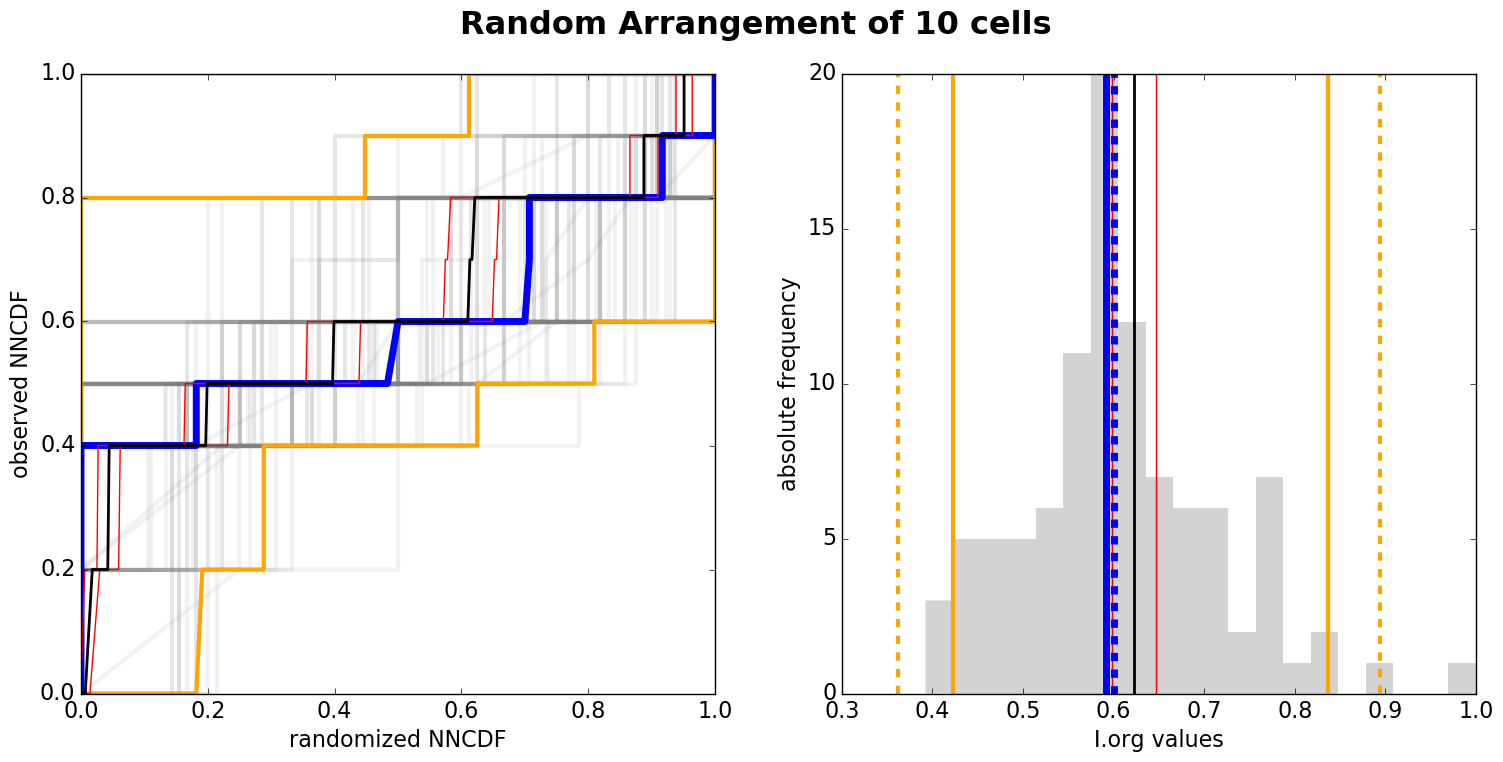

In [295]:
fig, a = pl.subplots( ncols = 2, figsize = (18,8))
pl.suptitle('Random Arrangement of %d cells' % ncells, fontsize = 'x-large', fontweight = 'bold')
pl.sca(a[0])
for i in range( len( Fs ) ):
    pl.plot(Fs[i], Fo, color = 'gray', alpha = 0.1, lw = 3)
pl.plot(Fml, Fo, color = 'orange',lw = 3)
pl.plot(Fmh, Fo, color = 'orange',lw = 3)
pl.plot(Fm, Fo, color = 'blue',lw = 5)

pl.plot(Fml_I, Fo_I, color = 'red',lw = 1)
pl.plot(Fmh_I, Fo_I, color = 'red',lw = 1)
pl.plot(Fm_I, Fo_I, color = 'black',lw = 2)

pl.xlabel('randomized NNCDF')
pl.ylabel('observed NNCDF')
pl.xlim(0,1)
pl.ylim(0,1)




    
pl.sca(a[1])
pl.hist(Iorg, 20, color = 'lightgray', lw = 0)

pl.axvline( LW,  color = 'orange',lw = 3)
pl.axvline( UP,  color = 'orange',lw = 3)
pl.axvline( Ior,  color = 'blue',lw = 5)

pl.axvline( LW_I,  color = 'red',lw = 1)
pl.axvline( UP_I,  color = 'red',lw = 1)
pl.axvline( Ior_I,  color = 'black',lw = 2)

pl.axvline( np.trapz(Fo, Fml) , ls = '--', color = 'orange',lw = 3)
pl.axvline( np.trapz(Fo, Fmh),  ls = '--',color = 'orange',lw = 3)
pl.axvline( np.trapz(Fo, Fm),  ls = '--',color = 'blue',lw = 5)



pl.xlabel('I.org values')
pl.ylabel('absolute frequency')


pl.savefig('Iorg_test_ncell%d.jpg' % ncells)

## Test I.org for 100 cells

In [297]:
ncells = 100
xpos = np.random.uniform(xbins.min(), xbins.max(), ncells)
ypos = np.random.uniform(ybins.min(), ybins.max(), ncells)
sizes = np.random.uniform( 4, 50, ncells)

In [298]:
Iorg, Ior, UP, LW, dist_bins, Fo, Fs, Fm, Fmh, Fml = calculate_Iorg(xpos, ypos, sizes, egrid, full_output=True)

Ior_I, UP_I, LW_I, dist_bins_I, Fo_I, Fs_I, Fm_I, Fmh_I, Fml_I = calculate_Iorg_Ieda(xpos, ypos, sizes, egrid, full_output=True)



(100,) (100,) (100,)
   BOOTSTRAPING
number of repetitions =  100


/mnt/lustre01/sw/rhel6-x64/python/python-2.7.12-gcc49/lib/python2.7/site-packages/ipykernel_launcher.py:35: RuntimeWarning: invalid value encountered in less_equal
/mnt/lustre01/sw/rhel6-x64/python/python-2.7.12-gcc49/lib/python2.7/site-packages/ipykernel_launcher.py:38: RuntimeWarning: invalid value encountered in less_equal


   I_org =  0.51
   UP =  0.58288103043
   LW =  0.442913616241
shape Fo = (1000,)
shape Fs = (100, 1000)
   BOOTSTRAPING
number of repetitions =  100
   ORGANISATION INDEX
   I_org =  0.51
   UP =  0.498162784011
   LW =  0.517229215989
shape Fo = (1000,)
shape Fs = (100, 1000)


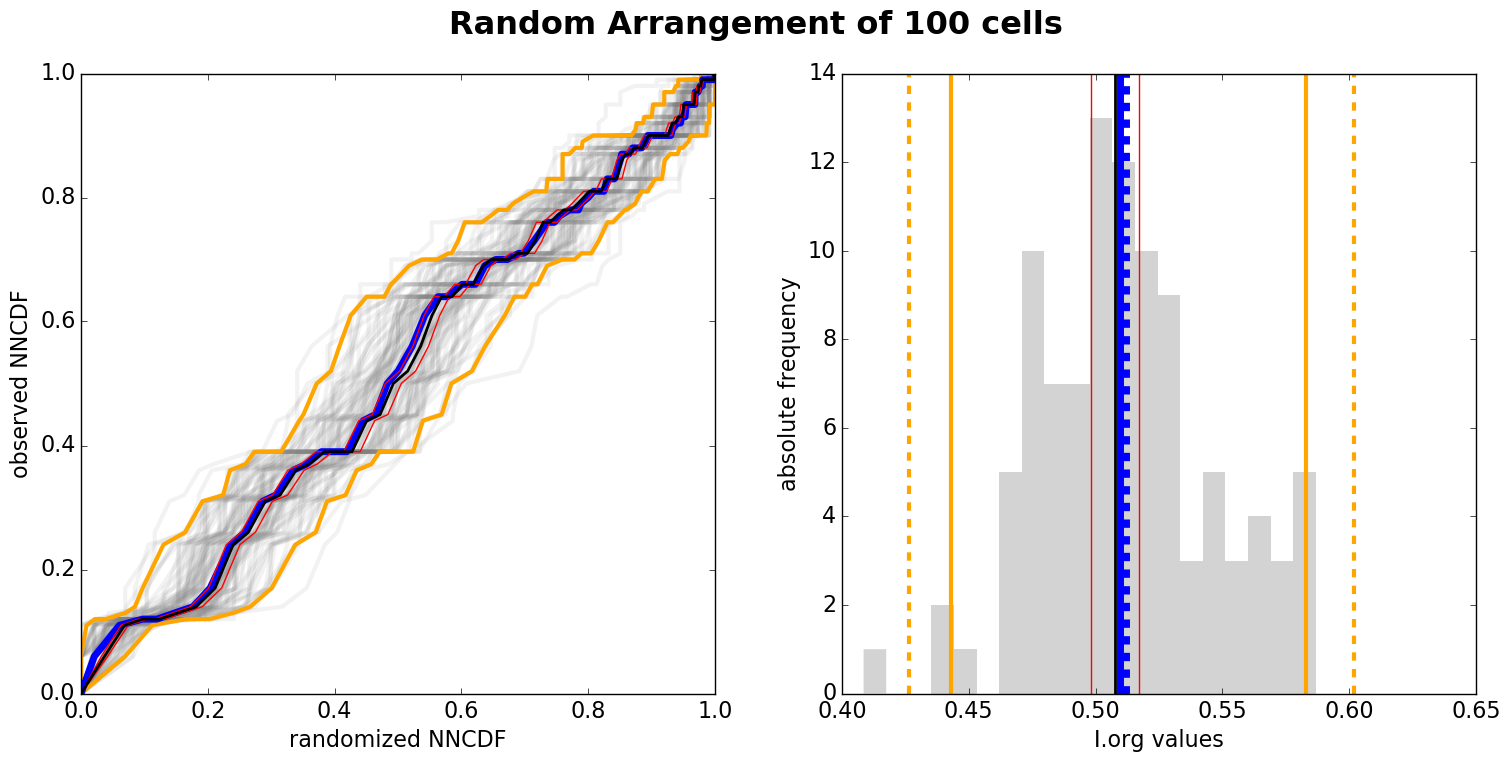

In [299]:
fig, a = pl.subplots( ncols = 2, figsize = (18,8))
pl.suptitle('Random Arrangement of %d cells' % ncells, fontsize = 'x-large', fontweight = 'bold')
pl.sca(a[0])
for i in range( len( Fs ) ):
    pl.plot(Fs[i], Fo, color = 'gray', alpha = 0.1, lw = 3)
pl.plot(Fml, Fo, color = 'orange',lw = 3)
pl.plot(Fmh, Fo, color = 'orange',lw = 3)
pl.plot(Fm, Fo, color = 'blue',lw = 5)

pl.plot(Fml_I, Fo_I, color = 'red',lw = 1)
pl.plot(Fmh_I, Fo_I, color = 'red',lw = 1)
pl.plot(Fm_I, Fo_I, color = 'black',lw = 2)

pl.xlabel('randomized NNCDF')
pl.ylabel('observed NNCDF')
pl.xlim(0,1)
pl.ylim(0,1)



    
pl.sca(a[1])
pl.hist(Iorg, 20, color = 'lightgray', lw = 0)

pl.axvline( LW,  color = 'orange',lw = 3)
pl.axvline( UP,  color = 'orange',lw = 3)
pl.axvline( Ior,  color = 'blue',lw = 5)

pl.axvline( LW_I,  color = 'red',lw = 1)
pl.axvline( UP_I,  color = 'red',lw = 1)
pl.axvline( Ior_I,  color = 'black',lw = 2)

pl.axvline( np.trapz(Fo, Fml) , ls = '--', color = 'orange',lw = 3)
pl.axvline( np.trapz(Fo, Fmh),  ls = '--',color = 'orange',lw = 3)
pl.axvline( np.trapz(Fo, Fm),  ls = '--',color = 'blue',lw = 5)



pl.xlabel('I.org values')
pl.ylabel('absolute frequency')


pl.savefig('Iorg_test_ncell%d.jpg' % ncells)

### See if it is calibrated ...

In [281]:
%%capture

Nran = 200

ncells = 10

UPvec = []
LWvec = []
Iorvec = []
for i in range(Nran):
    xpos = np.random.uniform(xbins.min(), xbins.max(), ncells)
    ypos = np.random.uniform(ybins.min(), ybins.max(), ncells)
    sizes = np.random.uniform( 4, 50, ncells)
    Iorg, Ior, UP, LW, dist_bins, Fo, Fs, Fm, Fmh, Fml = calculate_Iorg(xpos, ypos, sizes, egrid, full_output=True)

    Iorvec += [Ior,]
    UPvec += [UP,]
    LWvec += [LW,]
    

fraction of clustered cells:  0.0
fraction of regular cells:    1.0


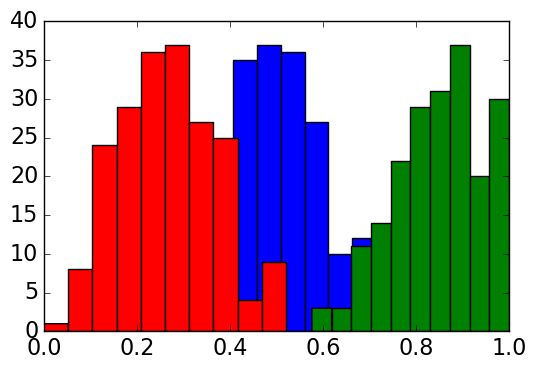

In [282]:
pl.hist(Iorvec)
pl.hist(UPvec)
pl.hist(LWvec)

print 'fraction of clustered cells: ', (np.array(UPvec) < 0.5).sum() / (0.01 * Nran)
print 'fraction of regular cells:   ', (np.array(LWvec) > 0.5).sum() / (0.01 * Nran)

